# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

plt.style.use('fivethirtyeight')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set(style="whitegrid", font_scale=1.1)
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Data points count: {:d}".format(critics.shape[0]))
print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Data points count: 15561
Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


Average Rating per critic spans from 0.35 to 0.82
Average of Average Rating per critic: 0.61
Critic rating labels: fresh, rotten, none


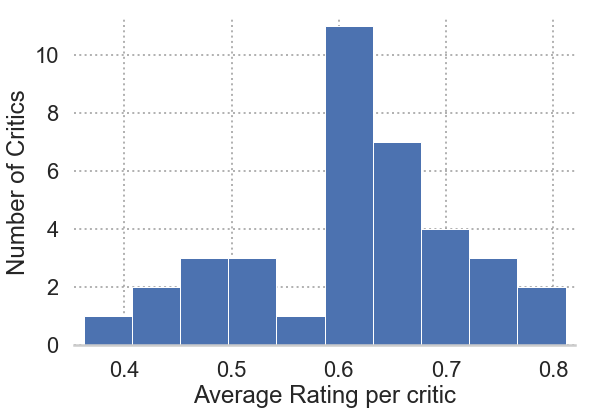

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

plt.figure(figsize=(8,6))
ax = means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
ax.set_xlabel("Average Rating per critic")
ax.set_ylabel("Number of Critics")
ax.set_yticks([0, 2, 4, 6, 8, 10])

sns.despine(right=True, top=True, left=True)
ax.grid(color="grey", linestyle='dotted', alpha=0.6)
ax.margins(0.02)
print("Average Rating per critic spans from {:.2f} to {:.2f}".format(plt.xlim()[0], plt.xlim()[1]))
print("Average of Average Rating per critic: {:.2f}".format(means[counts > 100].mean()))
print("Critic rating labels: {}".format(", ".join(critics.fresh.unique())))

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

At first glance, there seems some strong traction toward higher average rating per critic (i.e., 0.6+) given that rating ranges from 0.0 to 1.0. Based on shape of distribution, it shows unbalanced bimodal trend. Also, keep in mind that the histogram only reveals average rating of critics who has reviewed more than 100 movies. 

All in all, almost none of critics extremely critical because left peak located at 0.5 which is the middle, and most critics leave generous critiques (0.6+). Also, noticing the range of average rating per critic, it actually spans from 0.35 to 0.82; therefore, when we consider whether a movie is good or bad based on critic rating, we would consider 0.61 (average value) threshold point. 

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *__conditionally independent__* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, shuffle=True)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_predicted = clf.predict(X_train)
y_test_predicted = clf.predict(X_test)

train_score = accuracy_score(y_train, y_train_predicted)
test_score = accuracy_score(y_test, y_test_predicted)

print('Accuracy on training data: {:.3f}'.format(train_score))
print('Accuracy on test data: {:.3f}'.format(test_score))

Accuracy on training data: 0.920
Accuracy on test data: 0.774


According to the accuracy scores, we can tell the model overfits the training data and does not generalize enough. We can assume that the model has high variance and low bias. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

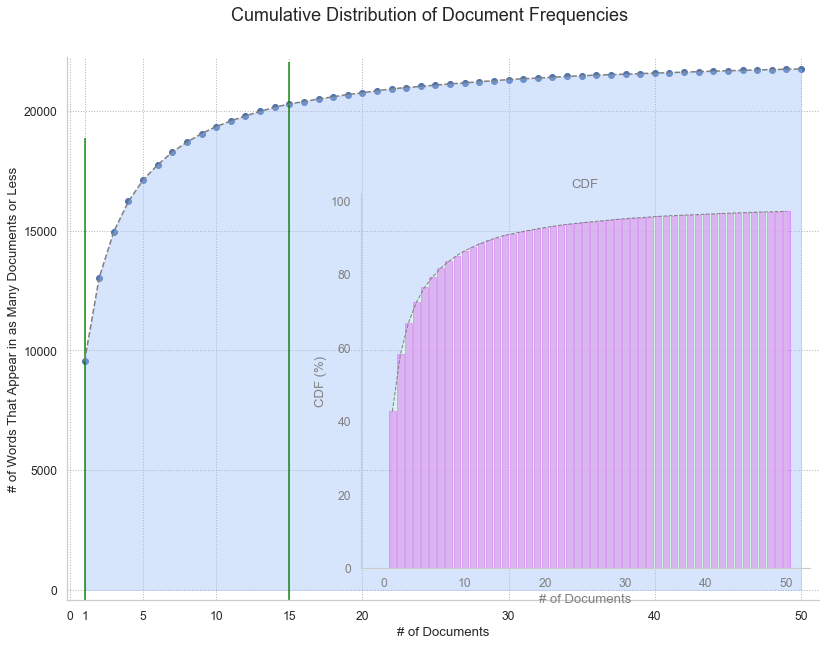

In [8]:
def plot_cdf(X):
    counts = np.ravel(np.sum(X, axis = 0))

    x_range = np.arange(51)
    cum_counts = np.empty(51)
    percentages = np.empty(51)
    num = len(counts)
    for i in x_range:
        cum_counts[i] = (counts <= i).sum()
    percentages = cum_counts / num * 100

    sns.set(style="whitegrid", font_scale=1.1)
    fig, ax = plt.subplots(figsize = (12,10))

    ax.plot(x_range[1:], cum_counts[1:], linestyle='dashed', color='grey', lw=1.5,)
    ax.scatter(x_range[1:], cum_counts[1:])
    ax.fill_between(x_range[1:], cum_counts[1:], 0, color='#9dc0f9', alpha=0.4)
    ax.vlines(1, 0, 0.85, transform=ax.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
    ax.vlines(15, 0, 0.99, transform=ax.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
    sns.despine(right=True, top=True, left=True)
    ax.grid(color="grey", linestyle='dotted', alpha=0.6)
    ax.margins(0.02)
    ax.set_xticks([0, 1, 5, 10, 15, 20, 30, 40, 50])

    ## set inner plot
    rect = [0.42, 0.17, 0.52, 0.52]
    ax2 = fig.add_axes(rect)
    ax2.grid(False)
    ax2.patch.set_alpha(0.0)
    sns.despine(left=False)

    ax2.plot(x_range[1:], percentages[1:], linestyle='dashed', color='grey', lw=1)
    ax2.fill_between(x_range[1:], percentages[1:], 0, color='#d9f9e6', alpha=0.7)
    ax2.bar(x_range, percentages, align='center', color='#e100ff', edgecolor='#e100ff', alpha=0.25)

    ax.set_xlabel('# of Documents')
    ax.set_ylabel('# of Words That Appear in as Many Documents or Less')
    plt.suptitle('Cumulative Distribution of Document Frequencies', fontsize=18, y=0.95)

    ax2.set_xlabel('# of Documents',color = 'grey')
    ax2.set_ylabel('CDF (%)', color = 'grey')
    ax2.set_title('CDF', color = 'grey')
    ax2.tick_params( colors='grey');
    
plot_cdf(X)

Looking at the graph above, the curve begins climing right off of 1 and gets onto a plateau from 15. Therefore, good candidates for min_df and max_df seem 1 and 15.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [9]:
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, valid in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[valid], y[valid]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [10]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [11]:
itrain, itest = train_test_split(range(critics.shape[0]), test_size=0.3)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itrain] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [12]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 1
best_max_df = 15

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask] # 70%
    ytrainthis = ythis[mask] # 70%
    
    clf = MultinomialNB(alpha=alpha)
    score_cv = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    
    if score_cv > maxscore:
        best_alpha = alpha
        maxscore = score_cv
    

In [13]:
print("Optimal alpha: {}".format(best_alpha))

Optimal alpha: 1


### Q. What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?
Recall description above about the Bayes' Theorem, we have: 

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(f \vert c)$ is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. Since the Naive Bayes models assume conditional independence among 
features, 

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal, and $P(c \vert f)$ is proportional to $P(f \vert c)$. This is the key point of maximum likelihood. For convenience of computation, we employ logarithm. Then, 

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

__Since logarithm function is convex if we find the maximum value of log-likelihood function, that attests the maximum value of $P(f \vert c)$, and thus of $P(c \vert f)$ with the given parameter - here, it is $\alpha$__. This is why we use log-likelihood as the score mean **in order to find the optimal alpha**.

### Q. Without writing any code, what do you think would happen if you choose a value of  $\alpha$ that is too high?
According to scikit-learn guide, 

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the total count of all features for class $c$ and $N_i$ is the number of times feature $i$ was seen globally. The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. If $\alpha$ is too high, $P(f_i \vert c) \approx \frac{1}{N_i}$ which is a constant. Therefore, the multinomial NB model loses its power to determine classes correctly because class-related value $\frac{N_{ic}}{N_c}$ is transferred to global value $\frac{1}{N_i}$.

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [14]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.924899
Accuracy on test data:     0.758407


In [15]:
print("Confusion matrix:")
print(confusion_matrix(ytest, clf.predict(xtest)))

Confusion matrix:
[[1113  721]
 [ 407 2428]]


The classifier does not improve significantly better. The default model is as good as best model. The reason there is little difference is default model use $\alpha = 1.0$ which is same as best $\alpha$ we found, and min_df also is basically same because that a document frequency lower than 0 is equivalent to a document frequency lower than 1. 

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [16]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0] # label 0 is rotten
ind = np.argsort(probs) # note that it's in ascending order

good_words = words[ind[:10]] # small possibility of rotten means a good word
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p))) # because p = p(rotten|word)
     
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             delight 0.97
           absorbing 0.96
            touching 0.96
            hypnotic 0.95
            expertly 0.95
              superb 0.95
              richly 0.95
                myth 0.95
           seductive 0.95
              loving 0.94
Bad words	     P(fresh | word)
          lackluster 0.10
             unfunny 0.09
             witless 0.08
     disappointingly 0.08
               bland 0.08
            sluggish 0.07
           pointless 0.07
       unfortunately 0.06
          uninspired 0.05
                lame 0.04


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

Recall, 

$$P(c \vert f) \propto P(f \vert c) P(c) \hspace{1in} - eq. (1)$$  
$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) \hspace{0.6in} - eq. (2)$$
With identity matrix, we only have one feature per row; therefore, eq. (2) turns to $P(f \vert c)  = P(f_i \vert c)$. $P(f_i \vert c)$ is the probability that we see feature $f_i$ given that this document is actually in class c, herein feature $f_i$ corresponds to $i^{th}$ word in the vocabulary set. Simply put, in this case, __the review comprises of one word and $\mathbf{P(word(f) \vert fresh(c))}$ is the probability that we see a word when the comment is fresh__. 

Notice that $P(c_{fresh})$ is a constant because it is just $\frac{N_
{fresh}}{N}$ where $N_{fresh}$ is the total count of all features for class fresh, p (feature number) and $N$ is the total number of reviews. According to eq. (1), __if we know $\mathbf{P(c)}$ is a constant, we can simply regard $\mathbf{P(c \vert f)}$ as $\mathbf{P(f \vert c)}$ - this is why we can determine if a word is good word or bad__. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [17]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5] # rotten actually but predicted as fresh
bad_fresh = np.argsort(prob[y == 1])[-5:] # fresh actually but predicted as rotten

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?

As a depiction of a loving-turbulent relationship between a single mom (Susan Sarandon) and her rebellious teenage daughter (Natalie Portman), Wang's meller is nicely crafted but old-fashioned like Hollywood's weepies of yesteryear.

If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of the vagaries of the human soul.

At the center of every swirling storm is a place of placid inertia, safe and still -- and not very exciting. And it's where Affleck and Bullock spend

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [18]:
test_vec = vectorizer.transform(["This movie is not remarkable, touching or superb in any way"])
predicted = clf.predict(test_vec)[0]
if predicted == 0:
    print("'This movie is not remarkable, touching or superb in any way' is predicted to get 'rotten'.")
else:
    print("'This movie is not remarkable, touching or superb in any way' is predicted to get 'fresh'.")

'This movie is not remarkable, touching or superb in any way' is predicted to get 'fresh'.


Based on the result from In \[16] and \[17], this should come as no surprise, because this test sentence is mostly composed of positive words ('remarkable', 'touching', 'superb') and one negative word ('not'). Predicting the label, the model multiplies probabilities of each feature given the class and chooses the label of biggest likelihood. Therefore, combination of three strong good words and one bad word is predicted "good words", that is, fresh.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

## 0. Use tfidf features instead of countvectorier

In [19]:
## Xtfidf & ytfidf
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english') # unigram

Xtfidf= tfidfvectorizer.fit_transform(critics.quote)
ytfidf = (critics.fresh == 'fresh').values.astype(np.int)

xtrain=Xtfidf[mask]
ytrain=ytfidf[mask]
xtest=Xtfidf[~mask]
ytest=ytfidf[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.846217
Accuracy on test data:     0.711930


Using default tfidfvectorizer, test accuracy has deteriorated even though variance has reduced. 

## 1. Try bigram, trigram tfidf
I will test with bigram-only, trigram-only, unigram-bigram, unigram-bigram-trigram tfidf models and will find the best model.

In [20]:
## Xtfidf & ytfidf
tfidf_bigram_only = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(2,2))
tfidf_trigram_only = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(3,3))
tfidf_upto_bigram = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1,2))
tfidf_upto_trigram = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1,3))

ytfidf = (critics.fresh == 'fresh').values.astype(np.int)

tfidfs = [tfidfvectorizer, tfidf_bigram_only, tfidf_trigram_only, tfidf_upto_bigram, tfidf_upto_trigram]
desc = ['unigram', 'bigram', 'trigram', 'uni-bigram', 'uni-bi-trigram']
train_results = []
test_results = []

for i, tfidf in enumerate(tfidfs):
    Xtfidf = tfidf.fit_transform(critics.quote)

    xtrain=Xtfidf[mask]
    ytrain=ytfidf[mask]
    xtest=Xtfidf[~mask]
    ytest=ytfidf[~mask]

    clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

    #your turn. Print the accuracy on the test and training dataset
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)
    
    print('{}'.format(desc[i]))
    print("Accuracy on training data: {:2f}".format(training_accuracy))
    print("Accuracy on test data:     {:2f}".format(test_accuracy))
    
    train_results.append(training_accuracy)
    test_results.append(test_accuracy)

unigram
Accuracy on training data: 0.846217
Accuracy on test data:     0.711930
bigram
Accuracy on training data: 0.993298
Accuracy on test data:     0.617477
trigram
Accuracy on training data: 0.980903
Accuracy on test data:     0.607625
uni-bigram
Accuracy on training data: 0.922696
Accuracy on test data:     0.651317
uni-bi-trigram
Accuracy on training data: 0.967499
Accuracy on test data:     0.633326


n-gram tfidf models show no improvment in test accuracy. Therefore, I will stick to CountVectorizer. Now, let us try with different alphas using GridSearchCV from sklearn. 

In [21]:
def make_vectorizers(min_df = 0):
    unigram = CountVectorizer(min_df=min_df, stop_words='english')
    bigram = CountVectorizer(min_df=min_df, stop_words='english', ngram_range=(2,2))
    trigram = CountVectorizer(min_df=min_df, stop_words='english', ngram_range=(3,3))
    upto_bigram = CountVectorizer(min_df=min_df, stop_words='english', ngram_range=(1,2))
    upto_trigram = CountVectorizer(min_df=min_df, stop_words='english', ngram_range=(1,3))

    vectorizers = [unigram, bigram, trigram, upto_bigram, upto_trigram]
    return vectorizers

def find_best_model(vectorizers, random_state=1111, test_size=0.3, cv=10):
    
    itrain, itest = train_test_split(range(critics.shape[0]), test_size=test_size, random_state=random_state)
    mask = np.zeros(critics.shape[0], dtype=np.bool)
    mask[itrain] = True
    models = []
    ngrams = ['unigram', 'bigram', 'trigram', 'upto_bigram', 'upto_trigram']
    vecs = []
    
    best_test_score = -np.inf
    
    for i,vec in enumerate(vectorizers):
        X,y = make_xy(critics, vec)
        
        X_train=X[mask]
        y_train=y[mask]
        X_test=X[~mask]
        y_test=y[~mask]
        
        parameters = {'alpha': [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5]}
        clf = MultinomialNB()
        bayes_cv = GridSearchCV(clf, parameters, cv = cv, scoring='accuracy')
        bayes_cv.fit(X_train, y_train)
             
        models.append(bayes_cv.best_estimator_)
        vecs.append(vec)
        
        if bayes_cv.best_score_ > best_test_score:
            best_test_score = bayes_cv.best_score_
            best_model_idx = i
            
    best_model = models[best_model_idx]
    best_vectorizer = vecs[best_model_idx]
    
    print('Best CV Score: {:.3f}'.format(best_test_score))
    print('ngram: {}'.format(ngrams[best_model_idx]))
    print('Best model: {}'.format(best_model))

    return best_model, best_vectorizer

In [22]:
best_models = []
best_vectorizers = []
for mindf in range(1, 10):
    print("min_df: {}".format(mindf))
    best, best_vectorizer = find_best_model(make_vectorizers(min_df=mindf), random_state=7979)
    best_models.append(best)
    best_vectorizers.append(best_vectorizer)
    print()

min_df: 1
Best CV Score: 0.746
ngram: unigram
Best model: MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

min_df: 2
Best CV Score: 0.748
ngram: unigram
Best model: MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

min_df: 3
Best CV Score: 0.747
ngram: unigram
Best model: MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

min_df: 4
Best CV Score: 0.746
ngram: unigram
Best model: MultinomialNB(alpha=2, class_prior=None, fit_prior=True)

min_df: 5
Best CV Score: 0.746
ngram: unigram
Best model: MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

min_df: 6
Best CV Score: 0.744
ngram: unigram
Best model: MultinomialNB(alpha=2, class_prior=None, fit_prior=True)

min_df: 7
Best CV Score: 0.744
ngram: unigram
Best model: MultinomialNB(alpha=2, class_prior=None, fit_prior=True)

min_df: 8
Best CV Score: 0.743
ngram: unigram
Best model: MultinomialNB(alpha=2, class_prior=None, fit_prior=True)

min_df: 9
Best CV Score: 0.742
ngram: unigram
Best model: Multinom

Best result is given when min_df = 2 and alpha = 1.5

In [23]:
## retrieve best model and best vectorizer
model = best_models[1]
vectorizer = best_vectorizers[1]

X, y = make_xy(critics, vectorizer)

X_train=X[mask]
y_train=y[mask]
X_test=X[~mask]
y_test=y[~mask]

training_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print("Accuracy on training data: {:.3f}".format(training_accuracy))
print("Accuracy on test data:     {:.3f}".format(test_accuracy))

Accuracy on training data: 0.859
Accuracy on test data:     0.857


There shows significant improvement in test accuracy and reduction in variance. Now our test accuracy is 0.857. 

## 2. Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

training_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print("Accuracy on training data: {:.3f}".format(training_accuracy))
print("Accuracy on test data:     {:.3f}".format(test_accuracy))

Accuracy on training data: 0.982
Accuracy on test data:     0.680


With default Random Forest model, we observe serious overfitting. 

In [25]:
params = {
            "max_depth": [5, 10, 20, 50, 100],
            "min_samples_split": [2, 3, 5, 10]
}

rf = RandomForestClassifier(n_estimators=10)

grid_search = GridSearchCV(rf, param_grid=params, cv=10)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

training_accuracy = best_rf.score(X_train, y_train)
test_accuracy = best_rf.score(X_test, y_test)

print("Accuracy on training data: {:.3f}".format(training_accuracy))
print("Accuracy on test data:     {:.3f}".format(test_accuracy))

Accuracy on training data: 0.811
Accuracy on test data:     0.677


We can conclude Random Forest is not a good fit for dataset.